## Scenario 1: building a model trained on stream gauges

### a) Importing necessary libraries

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import random as rn
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
import pickle
import matplotlib.pyplot as plt
import shap
import warnings



# Set random seeds for reproducibility
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)


### b) Reading the stream gauges data for hurricane Ida

In [2]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Ida.csv', header=0)
df['Flood'] = df['Max_Gage_height']-df['Mean_Gage_height']

df

,SiteNumber,SiteLongit,SiteLatitu,Flow accumulation,Distance to sea,Slope,TWI,Curvature,Upstream Area,Altitude,Distance to storm track,Soil moisture,Wind speed,Rain,Storm surge,Mean_Gage_height,Max_Gage_height,Flood
0,1398000,-74.827778,40.473333,878333,0.556637,0.501344,18.316236,-2.059870e+09,65475300,109.46,0.435280,0.428718,27.3923,0.008407,2.13291,3.426463,19.80,16.373537
1,1397420,-74.742500,40.501944,7613110,0.471549,0.208936,21.216994,-6.643140e+08,469030000,60.40,0.439363,0.428718,27.9522,0.008362,1.88838,6.689451,27.10,20.410549
2,1401000,-74.681944,40.333056,1462430,0.437685,1.261950,17.966622,-1.171460e+09,117541000,62.23,0.260336,0.411208,27.0814,0.008822,1.98415,3.162708,18.10,14.937292
3,1401650,-74.648889,40.468056,176373,0.378003,2.695280,15.115324,-1.920260e+10,13149800,58.85,0.381061,0.428718,28.2679,0.011358,1.69922,4.686875,14.03,9.343125
4,1401750,-74.617500,40.440000,5610190,0.349136,14.066700,16.920150,2.726460e+10,453287000,26.52,0.345462,0.430111,28.4742,0.014453,1.66287,5.366979,23.22,17.853021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,1374505,-73.607472,41.394583,2592720,0.370593,12.305600,16.286273,9.700830e+09,205081000,315.74,0.985841,0.279366,31.5753,1.533940,1.28213,3.757292,6.26,2.502708
112,1374531,-73.639583,41.373389,2924290,0.360568,1.420260,18.546203,3.441800e+08,219196000,270.50,0.974283,0.352202,31.9977,1.286300,1.29693,2.472708,7.65,5.177292
113,1374781,-73.591472,41.327361,552958,0.303099,5.531940,15.547339,-1.934700e+09,33444100,331.84,0.916809,0.258539,31.7314,1.619680,1.27567,2.266146,4.77,2.503854
114,1374559,-73.759583,41.470472,369281,0.481995,14.157900,14.192663,-8.706530e+09,28273400,586.60,1.100598,0.381326,30.7331,0.494721,1.33736,1.503437,4.27,2.766563


### c) Adding new features that consider interactions between existing features, identified through the forward feature selection method.

In [3]:
df["Altittude:Storm surge"] = df["Altitude"] * df["Storm surge"]
df["Storm surge:Flow accumulation"] = df["Storm surge"] * df["Flow accumulation"]
df["Altittude:Soil moisture"] = df["Altitude"] * df["Soil moisture"]
df["Storm surge:Wind speed"] = df["Storm surge"] * df["Wind speed"]
df["Storm surge:Soil moisture"] = df["Storm surge"] * df["Soil moisture"]
df["Storm surge:Mean_Gage_height"] = df["Mean_Gage_height"] * df["Storm surge"]
df["Flow accumulation:Soil moisture"] = df["Flow accumulation"] * df["Soil moisture"]



features = [
    "Altitude",
    "Storm surge",
    "Flow accumulation",
    "Soil moisture",
    "Mean_Gage_height",    
    "Altittude:Storm surge",
    "Storm surge:Flow accumulation",
    "Altittude:Soil moisture",
    "Storm surge:Soil moisture",       
    "Storm surge:Mean_Gage_height",   
    "Flow accumulation:Soil moisture"
]


#define the target variable
y = df['Flood']* 0.3048   #change ft to meter
x = df[features]
x.shape

(116, 11)

### d) Spliting and Scaling data

In [4]:
# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x.values, y.values, test_size=0.2, random_state=64)


# Standardize the numerical features
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest)

### f) Creating a model 

In [5]:
def create_model(num_layers, num_units, regularization_rate, optimizer, activations):
    # Assuming 'features' is defined globally or this part of the code is adjusted to include it
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(len(features),)))
    
    # Dynamically add layers
    for _ in range(int(num_layers)):
        model.add(tf.keras.layers.Dense(int(num_units), activation=activations,
                                        kernel_initializer=tf.keras.initializers.he_normal(seed=1),
                                        bias_initializer='zeros',
                                        kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))

    model.add(tf.keras.layers.Dense(1, kernel_initializer='he_normal', bias_initializer='zeros'))
    
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    
    return model

# Define the best hyperparameters
best_hyperparameters = {
    'units': 64,
    'regularization_rate': 0.10404983,
    'optimizer': 'sgd',
    'num_layers': 3,
    'epochs': 2000,
    'batch_size': 16,
    'activations': 'elu'
}

# Create and train the model with the best hyperparameters
model = create_model(
    num_layers= 3,
    num_units= 50,
    regularization_rate= 0.01,
    optimizer= 'sgd',
    activations= 'elu',
)


# Define a custom callback function
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_loss'] < .76 and logs['loss']< .76:
            self.model.stop_training = True

# Create an instance of the custom callback
custom_early_stopping = CustomEarlyStopping()

# Define model checkpointing
model_checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

# Train the model and generate the training history
history = model.fit(Xtrain_scaled, Ytrain, validation_data=(Xtest_scaled, Ytest), batch_size=best_hyperparameters['batch_size'], epochs=best_hyperparameters['epochs'], callbacks=[custom_early_stopping, model_checkpoint])


Epoch 1/2000
6/6 [==============================] - 1s 53ms/step - loss: 5.2538 - mean_absolute_error: 2.2887 - val_loss: 4.7899 - val_mean_absolute_error: 1.8300
Epoch 2/2000
6/6 [==============================] - 0s 12ms/step - loss: 4.4995 - mean_absolute_error: 1.5426 - val_loss: 4.2848 - val_mean_absolute_error: 1.3318
Epoch 3/2000
6/6 [==============================] - 0s 12ms/step - loss: 4.1538 - mean_absolute_error: 1.2034 - val_loss: 4.0698 - val_mean_absolute_error: 1.1233
Epoch 4/2000
6/6 [==============================] - 0s 13ms/step - loss: 4.0090 - mean_absolute_error: 1.0652 - val_loss: 4.0345 - val_mean_absolute_error: 1.0948
Epoch 5/2000
6/6 [==============================] - 0s 9ms/step - loss: 3.8963 - mean_absolute_error: 0.9590 - val_loss: 3.8809 - val_mean_absolute_error: 0.9474
Epoch 6/2000
6/6 [==============================] - 0s 13ms/step - loss: 3.8143 - mean_absolute_error: 0.8835 - val_loss: 3.8079 - val_mean_absolute_error: 0.8808
Epoch 7/2000
6/6 [=====

6/6 [==============================] - 0s 7ms/step - loss: 2.8124 - mean_absolute_error: 0.4595 - val_loss: 3.0221 - val_mean_absolute_error: 0.6727
Epoch 102/2000
6/6 [==============================] - 0s 12ms/step - loss: 2.8239 - mean_absolute_error: 0.4764 - val_loss: 2.9752 - val_mean_absolute_error: 0.6311
Epoch 103/2000
6/6 [==============================] - 0s 6ms/step - loss: 2.7686 - mean_absolute_error: 0.4265 - val_loss: 2.9886 - val_mean_absolute_error: 0.6498
Epoch 104/2000
6/6 [==============================] - 0s 6ms/step - loss: 2.8315 - mean_absolute_error: 0.4952 - val_loss: 3.0195 - val_mean_absolute_error: 0.6859
Epoch 105/2000
6/6 [==============================] - 0s 7ms/step - loss: 2.7881 - mean_absolute_error: 0.4568 - val_loss: 3.0225 - val_mean_absolute_error: 0.6944
Epoch 106/2000
6/6 [==============================] - 0s 19ms/step - loss: 2.7838 - mean_absolute_error: 0.4579 - val_loss: 2.9324 - val_mean_absolute_error: 0.6096
Epoch 107/2000
6/6 [=========

Epoch 151/2000
6/6 [==============================] - 0s 7ms/step - loss: 2.5226 - mean_absolute_error: 0.4194 - val_loss: 2.7551 - val_mean_absolute_error: 0.6542
Epoch 152/2000
6/6 [==============================] - 0s 8ms/step - loss: 2.5204 - mean_absolute_error: 0.4217 - val_loss: 2.7732 - val_mean_absolute_error: 0.6771
Epoch 153/2000
6/6 [==============================] - 0s 7ms/step - loss: 2.5097 - mean_absolute_error: 0.4155 - val_loss: 2.7150 - val_mean_absolute_error: 0.6235
Epoch 154/2000
6/6 [==============================] - 0s 7ms/step - loss: 2.5211 - mean_absolute_error: 0.4316 - val_loss: 2.6996 - val_mean_absolute_error: 0.6126
Epoch 155/2000
6/6 [==============================] - 0s 7ms/step - loss: 2.5085 - mean_absolute_error: 0.4232 - val_loss: 2.7105 - val_mean_absolute_error: 0.6283
Epoch 156/2000
6/6 [==============================] - 0s 11ms/step - loss: 2.5185 - mean_absolute_error: 0.4381 - val_loss: 2.6761 - val_mean_absolute_error: 0.5985
Epoch 157/2000


Epoch 201/2000
6/6 [==============================] - 0s 14ms/step - loss: 2.3003 - mean_absolute_error: 0.4163 - val_loss: 2.4619 - val_mean_absolute_error: 0.5807
Epoch 202/2000
6/6 [==============================] - 0s 7ms/step - loss: 2.2558 - mean_absolute_error: 0.3761 - val_loss: 2.4798 - val_mean_absolute_error: 0.6026
Epoch 203/2000
6/6 [==============================] - 0s 16ms/step - loss: 2.2776 - mean_absolute_error: 0.4022 - val_loss: 2.4502 - val_mean_absolute_error: 0.5769
Epoch 204/2000
6/6 [==============================] - 0s 7ms/step - loss: 2.2628 - mean_absolute_error: 0.3914 - val_loss: 2.4881 - val_mean_absolute_error: 0.6192
Epoch 205/2000
6/6 [==============================] - 0s 21ms/step - loss: 2.2876 - mean_absolute_error: 0.4200 - val_loss: 2.4464 - val_mean_absolute_error: 0.5812
Epoch 206/2000
6/6 [==============================] - 0s 21ms/step - loss: 2.2827 - mean_absolute_error: 0.4192 - val_loss: 2.4427 - val_mean_absolute_error: 0.5819
Epoch 207/20

Epoch 251/2000
6/6 [==============================] - 0s 5ms/step - loss: 2.0733 - mean_absolute_error: 0.3831 - val_loss: 2.2990 - val_mean_absolute_error: 0.6110
Epoch 252/2000
6/6 [==============================] - 0s 6ms/step - loss: 2.0650 - mean_absolute_error: 0.3787 - val_loss: 2.3342 - val_mean_absolute_error: 0.6497
Epoch 253/2000
6/6 [==============================] - 0s 10ms/step - loss: 2.0671 - mean_absolute_error: 0.3840 - val_loss: 2.2231 - val_mean_absolute_error: 0.5425
Epoch 254/2000
6/6 [==============================] - 0s 6ms/step - loss: 2.0779 - mean_absolute_error: 0.3986 - val_loss: 2.2762 - val_mean_absolute_error: 0.5990
Epoch 255/2000
6/6 [==============================] - 0s 12ms/step - loss: 2.0767 - mean_absolute_error: 0.4006 - val_loss: 2.2179 - val_mean_absolute_error: 0.5439
Epoch 256/2000
6/6 [==============================] - 0s 6ms/step - loss: 2.0521 - mean_absolute_error: 0.3797 - val_loss: 2.3135 - val_mean_absolute_error: 0.6428
Epoch 257/2000

Epoch 301/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.8912 - mean_absolute_error: 0.3710 - val_loss: 2.1386 - val_mean_absolute_error: 0.6211
Epoch 302/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.8779 - mean_absolute_error: 0.3615 - val_loss: 2.1242 - val_mean_absolute_error: 0.6096
Epoch 303/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.9212 - mean_absolute_error: 0.4079 - val_loss: 2.1933 - val_mean_absolute_error: 0.6820
Epoch 304/2000
6/6 [==============================] - 0s 15ms/step - loss: 1.8868 - mean_absolute_error: 0.3766 - val_loss: 2.0818 - val_mean_absolute_error: 0.5731
Epoch 305/2000
6/6 [==============================] - 0s 10ms/step - loss: 1.9043 - mean_absolute_error: 0.3971 - val_loss: 2.1343 - val_mean_absolute_error: 0.6290
Epoch 306/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.8726 - mean_absolute_error: 0.3687 - val_loss: 2.0880 - val_mean_absolute_error: 0.5856
Epoch 307/2000

Epoch 351/2000
6/6 [==============================] - 0s 4ms/step - loss: 1.7681 - mean_absolute_error: 0.3998 - val_loss: 1.9671 - val_mean_absolute_error: 0.6009
Epoch 352/2000
6/6 [==============================] - 0s 13ms/step - loss: 1.7708 - mean_absolute_error: 0.4055 - val_loss: 1.8878 - val_mean_absolute_error: 0.5239
Epoch 353/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.7169 - mean_absolute_error: 0.3543 - val_loss: 1.9837 - val_mean_absolute_error: 0.6230
Epoch 354/2000
6/6 [==============================] - 0s 5ms/step - loss: 1.7418 - mean_absolute_error: 0.3821 - val_loss: 1.9518 - val_mean_absolute_error: 0.5937
Epoch 355/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.7193 - mean_absolute_error: 0.3624 - val_loss: 2.0195 - val_mean_absolute_error: 0.6644
Epoch 356/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.7266 - mean_absolute_error: 0.3727 - val_loss: 1.9669 - val_mean_absolute_error: 0.6146
Epoch 357/2000


Epoch 401/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.6426 - mean_absolute_error: 0.4085 - val_loss: 1.8419 - val_mean_absolute_error: 0.6095
Epoch 402/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.6113 - mean_absolute_error: 0.3797 - val_loss: 1.7685 - val_mean_absolute_error: 0.5383
Epoch 403/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.6011 - mean_absolute_error: 0.3716 - val_loss: 1.7919 - val_mean_absolute_error: 0.5639
Epoch 404/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.6157 - mean_absolute_error: 0.3884 - val_loss: 1.8236 - val_mean_absolute_error: 0.5981
Epoch 405/2000
6/6 [==============================] - 0s 10ms/step - loss: 1.5888 - mean_absolute_error: 0.3644 - val_loss: 1.8262 - val_mean_absolute_error: 0.6033
Epoch 406/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.6027 - mean_absolute_error: 0.3805 - val_loss: 1.8193 - val_mean_absolute_error: 0.5987
Epoch 407/2000


Epoch 451/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.4746 - mean_absolute_error: 0.3575 - val_loss: 1.7216 - val_mean_absolute_error: 0.6058
Epoch 452/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.4751 - mean_absolute_error: 0.3599 - val_loss: 1.7159 - val_mean_absolute_error: 0.6022
Epoch 453/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.4612 - mean_absolute_error: 0.3483 - val_loss: 1.7115 - val_mean_absolute_error: 0.5995
Epoch 454/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.4699 - mean_absolute_error: 0.3591 - val_loss: 1.7429 - val_mean_absolute_error: 0.6334
Epoch 455/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.4858 - mean_absolute_error: 0.3771 - val_loss: 1.7415 - val_mean_absolute_error: 0.6342
Epoch 456/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.4640 - mean_absolute_error: 0.3579 - val_loss: 1.6906 - val_mean_absolute_error: 0.5856
Epoch 457/2000
6

Epoch 501/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.3866 - mean_absolute_error: 0.3752 - val_loss: 1.6557 - val_mean_absolute_error: 0.6453
Epoch 502/2000
6/6 [==============================] - 0s 5ms/step - loss: 1.3904 - mean_absolute_error: 0.3806 - val_loss: 1.5756 - val_mean_absolute_error: 0.5668
Epoch 503/2000
6/6 [==============================] - 0s 16ms/step - loss: 1.3803 - mean_absolute_error: 0.3723 - val_loss: 1.5671 - val_mean_absolute_error: 0.5606
Epoch 504/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.3873 - mean_absolute_error: 0.3816 - val_loss: 1.6274 - val_mean_absolute_error: 0.6226
Epoch 505/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.3962 - mean_absolute_error: 0.3923 - val_loss: 1.6254 - val_mean_absolute_error: 0.6227
Epoch 506/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.3649 - mean_absolute_error: 0.3630 - val_loss: 1.6126 - val_mean_absolute_error: 0.6119
Epoch 507/2000


Epoch 551/2000
6/6 [==============================] - 0s 13ms/step - loss: 1.2906 - mean_absolute_error: 0.3715 - val_loss: 1.5150 - val_mean_absolute_error: 0.5978
Epoch 552/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.2895 - mean_absolute_error: 0.3730 - val_loss: 1.5329 - val_mean_absolute_error: 0.6175
Epoch 553/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.3089 - mean_absolute_error: 0.3940 - val_loss: 1.5359 - val_mean_absolute_error: 0.6217
Epoch 554/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.2776 - mean_absolute_error: 0.3641 - val_loss: 1.5132 - val_mean_absolute_error: 0.6006
Epoch 555/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.2719 - mean_absolute_error: 0.3600 - val_loss: 1.6003 - val_mean_absolute_error: 0.6896
Epoch 556/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.2894 - mean_absolute_error: 0.3792 - val_loss: 1.6107 - val_mean_absolute_error: 0.7013
Epoch 557/2000


Epoch 601/2000
6/6 [==============================] - 0s 9ms/step - loss: 1.2158 - mean_absolute_error: 0.3781 - val_loss: 1.4383 - val_mean_absolute_error: 0.6011
Epoch 602/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.2004 - mean_absolute_error: 0.3641 - val_loss: 1.4378 - val_mean_absolute_error: 0.6026
Epoch 603/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.2163 - mean_absolute_error: 0.3816 - val_loss: 1.4559 - val_mean_absolute_error: 0.6220
Epoch 604/2000
6/6 [==============================] - 0s 9ms/step - loss: 1.1853 - mean_absolute_error: 0.3521 - val_loss: 1.4803 - val_mean_absolute_error: 0.6486
Epoch 605/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.1785 - mean_absolute_error: 0.3471 - val_loss: 1.4884 - val_mean_absolute_error: 0.6577
Epoch 606/2000
6/6 [==============================] - 0s 9ms/step - loss: 1.2031 - mean_absolute_error: 0.3727 - val_loss: 1.4499 - val_mean_absolute_error: 0.6205
Epoch 607/2000
6

Epoch 651/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.1398 - mean_absolute_error: 0.3751 - val_loss: 1.4172 - val_mean_absolute_error: 0.6528
Epoch 652/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.1793 - mean_absolute_error: 0.4154 - val_loss: 1.3797 - val_mean_absolute_error: 0.6166
Epoch 653/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.1246 - mean_absolute_error: 0.3623 - val_loss: 1.4407 - val_mean_absolute_error: 0.6791
Epoch 654/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.1316 - mean_absolute_error: 0.3704 - val_loss: 1.4160 - val_mean_absolute_error: 0.6554
Epoch 655/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.1276 - mean_absolute_error: 0.3679 - val_loss: 1.5158 - val_mean_absolute_error: 0.7573
Epoch 656/2000
6/6 [==============================] - 0s 15ms/step - loss: 1.1508 - mean_absolute_error: 0.3926 - val_loss: 1.3193 - val_mean_absolute_error: 0.5623
Epoch 657/2000


Epoch 701/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.0323 - mean_absolute_error: 0.3321 - val_loss: 1.3492 - val_mean_absolute_error: 0.6497
Epoch 702/2000
6/6 [==============================] - 0s 5ms/step - loss: 1.0917 - mean_absolute_error: 0.3927 - val_loss: 1.4268 - val_mean_absolute_error: 0.7283
Epoch 703/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.0646 - mean_absolute_error: 0.3667 - val_loss: 1.3118 - val_mean_absolute_error: 0.6143
Epoch 704/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.0738 - mean_absolute_error: 0.3771 - val_loss: 1.3295 - val_mean_absolute_error: 0.6334
Epoch 705/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.0500 - mean_absolute_error: 0.3541 - val_loss: 1.2927 - val_mean_absolute_error: 0.5974
Epoch 706/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.0694 - mean_absolute_error: 0.3747 - val_loss: 1.2800 - val_mean_absolute_error: 0.5862
Epoch 707/2000
6

Epoch 751/2000
6/6 [==============================] - 0s 8ms/step - loss: 1.0058 - mean_absolute_error: 0.3634 - val_loss: 1.2526 - val_mean_absolute_error: 0.6112
Epoch 752/2000
6/6 [==============================] - 0s 5ms/step - loss: 1.0239 - mean_absolute_error: 0.3826 - val_loss: 1.3136 - val_mean_absolute_error: 0.6729
Epoch 753/2000
6/6 [==============================] - 0s 6ms/step - loss: 1.0166 - mean_absolute_error: 0.3762 - val_loss: 1.2652 - val_mean_absolute_error: 0.6253
Epoch 754/2000
6/6 [==============================] - 0s 7ms/step - loss: 1.0188 - mean_absolute_error: 0.3794 - val_loss: 1.2731 - val_mean_absolute_error: 0.6344
Epoch 755/2000
6/6 [==============================] - 0s 5ms/step - loss: 1.0043 - mean_absolute_error: 0.3665 - val_loss: 1.3303 - val_mean_absolute_error: 0.6932
Epoch 756/2000
6/6 [==============================] - 0s 18ms/step - loss: 1.0143 - mean_absolute_error: 0.3777 - val_loss: 1.1844 - val_mean_absolute_error: 0.5487
Epoch 757/2000


Epoch 801/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.9550 - mean_absolute_error: 0.3643 - val_loss: 1.1856 - val_mean_absolute_error: 0.5955
Epoch 802/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.9487 - mean_absolute_error: 0.3588 - val_loss: 1.2348 - val_mean_absolute_error: 0.6454
Epoch 803/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.9483 - mean_absolute_error: 0.3593 - val_loss: 1.2579 - val_mean_absolute_error: 0.6690
Epoch 804/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.9559 - mean_absolute_error: 0.3675 - val_loss: 1.2142 - val_mean_absolute_error: 0.6261
Epoch 805/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.9472 - mean_absolute_error: 0.3595 - val_loss: 1.2433 - val_mean_absolute_error: 0.6562
Epoch 806/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.9478 - mean_absolute_error: 0.3611 - val_loss: 1.2717 - val_mean_absolute_error: 0.6859
Epoch 807/2000
6

Epoch 851/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.9396 - mean_absolute_error: 0.3933 - val_loss: 1.1934 - val_mean_absolute_error: 0.6475
Epoch 852/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.9334 - mean_absolute_error: 0.3885 - val_loss: 1.2420 - val_mean_absolute_error: 0.6979
Epoch 853/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.9204 - mean_absolute_error: 0.3763 - val_loss: 1.2509 - val_mean_absolute_error: 0.7072
Epoch 854/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.9343 - mean_absolute_error: 0.3910 - val_loss: 1.2254 - val_mean_absolute_error: 0.6822
Epoch 855/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.9356 - mean_absolute_error: 0.3927 - val_loss: 1.1304 - val_mean_absolute_error: 0.5884
Epoch 856/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.9241 - mean_absolute_error: 0.3823 - val_loss: 1.2592 - val_mean_absolute_error: 0.7183
Epoch 857/2000
6

Epoch 901/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.8883 - mean_absolute_error: 0.3826 - val_loss: 1.1530 - val_mean_absolute_error: 0.6479
Epoch 902/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.8857 - mean_absolute_error: 0.3809 - val_loss: 1.1915 - val_mean_absolute_error: 0.6872
Epoch 903/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.8784 - mean_absolute_error: 0.3742 - val_loss: 1.3020 - val_mean_absolute_error: 0.7979
Epoch 904/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.8941 - mean_absolute_error: 0.3906 - val_loss: 1.0603 - val_mean_absolute_error: 0.5576
Epoch 905/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.8742 - mean_absolute_error: 0.3716 - val_loss: 1.0867 - val_mean_absolute_error: 0.5847
Epoch 906/2000
6/6 [==============================] - 0s 9ms/step - loss: 0.8609 - mean_absolute_error: 0.3592 - val_loss: 1.2109 - val_mean_absolute_error: 0.7096
Epoch 907/2000
6

Epoch 951/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.8408 - mean_absolute_error: 0.3726 - val_loss: 1.0243 - val_mean_absolute_error: 0.5566
Epoch 952/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.8555 - mean_absolute_error: 0.3880 - val_loss: 1.2024 - val_mean_absolute_error: 0.7348
Epoch 953/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.8715 - mean_absolute_error: 0.4043 - val_loss: 1.1637 - val_mean_absolute_error: 0.6971
Epoch 954/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.8552 - mean_absolute_error: 0.3889 - val_loss: 1.0879 - val_mean_absolute_error: 0.6215
Epoch 955/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.8286 - mean_absolute_error: 0.3623 - val_loss: 1.0697 - val_mean_absolute_error: 0.6041
Epoch 956/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.8400 - mean_absolute_error: 0.3746 - val_loss: 1.0772 - val_mean_absolute_error: 0.6118
Epoch 957/2000
6

Epoch 1001/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.8014 - mean_absolute_error: 0.3637 - val_loss: 1.0464 - val_mean_absolute_error: 0.6092
Epoch 1002/2000
6/6 [==============================] - 0s 10ms/step - loss: 0.8172 - mean_absolute_error: 0.3805 - val_loss: 1.0899 - val_mean_absolute_error: 0.6536
Epoch 1003/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.8058 - mean_absolute_error: 0.3700 - val_loss: 1.0308 - val_mean_absolute_error: 0.5957
Epoch 1004/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.7934 - mean_absolute_error: 0.3583 - val_loss: 1.0842 - val_mean_absolute_error: 0.6487
Epoch 1005/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.8284 - mean_absolute_error: 0.3936 - val_loss: 1.2829 - val_mean_absolute_error: 0.8480
Epoch 1006/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.8305 - mean_absolute_error: 0.3962 - val_loss: 1.1335 - val_mean_absolute_error: 0.6997
Epoch 100

Epoch 1100/2000
6/6 [==============================] - 0s 9ms/step - loss: 0.7628 - mean_absolute_error: 0.3794 - val_loss: 0.9792 - val_mean_absolute_error: 0.5959
Epoch 1101/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.7670 - mean_absolute_error: 0.3840 - val_loss: 0.9669 - val_mean_absolute_error: 0.5847
Epoch 1102/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.7647 - mean_absolute_error: 0.3828 - val_loss: 1.0922 - val_mean_absolute_error: 0.7104
Epoch 1103/2000
6/6 [==============================] - 0s 10ms/step - loss: 0.7225 - mean_absolute_error: 0.3409 - val_loss: 1.1502 - val_mean_absolute_error: 0.7686
Epoch 1104/2000
6/6 [==============================] - 0s 9ms/step - loss: 0.7631 - mean_absolute_error: 0.3819 - val_loss: 1.0341 - val_mean_absolute_error: 0.6534
Epoch 1105/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.7844 - mean_absolute_error: 0.4036 - val_loss: 1.1334 - val_mean_absolute_error: 0.7537
Epoch 110

Epoch 1199/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.7084 - mean_absolute_error: 0.3675 - val_loss: 1.0198 - val_mean_absolute_error: 0.6793
Epoch 1200/2000
6/6 [==============================] - 0s 13ms/step - loss: 0.7206 - mean_absolute_error: 0.3803 - val_loss: 0.9272 - val_mean_absolute_error: 0.5872
Epoch 1201/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.7396 - mean_absolute_error: 0.3998 - val_loss: 1.0202 - val_mean_absolute_error: 0.6806
Epoch 1202/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.7176 - mean_absolute_error: 0.3783 - val_loss: 0.9506 - val_mean_absolute_error: 0.6119
Epoch 1203/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.7656 - mean_absolute_error: 0.4268 - val_loss: 1.0165 - val_mean_absolute_error: 0.6777
Epoch 1204/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.6639 - mean_absolute_error: 0.3251 - val_loss: 1.0075 - val_mean_absolute_error: 0.6688
Epoch 120

Epoch 1298/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.6724 - mean_absolute_error: 0.3661 - val_loss: 0.9314 - val_mean_absolute_error: 0.6254
Epoch 1299/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.6652 - mean_absolute_error: 0.3593 - val_loss: 1.0077 - val_mean_absolute_error: 0.7024
Epoch 1300/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.6747 - mean_absolute_error: 0.3695 - val_loss: 0.9515 - val_mean_absolute_error: 0.6468
Epoch 1301/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.6786 - mean_absolute_error: 0.3738 - val_loss: 0.9514 - val_mean_absolute_error: 0.6463
Epoch 1302/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.6795 - mean_absolute_error: 0.3744 - val_loss: 0.8969 - val_mean_absolute_error: 0.5922
Epoch 1303/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.6844 - mean_absolute_error: 0.3797 - val_loss: 0.9251 - val_mean_absolute_error: 0.6205
Epoch 1304

Epoch 1397/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.6908 - mean_absolute_error: 0.4118 - val_loss: 1.0547 - val_mean_absolute_error: 0.7756
Epoch 1398/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.6420 - mean_absolute_error: 0.3633 - val_loss: 0.8656 - val_mean_absolute_error: 0.5873
Epoch 1399/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.6308 - mean_absolute_error: 0.3525 - val_loss: 1.0027 - val_mean_absolute_error: 0.7247
Epoch 1400/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.6157 - mean_absolute_error: 0.3377 - val_loss: 0.8637 - val_mean_absolute_error: 0.5856
Epoch 1401/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.6433 - mean_absolute_error: 0.3655 - val_loss: 0.9027 - val_mean_absolute_error: 0.6249
Epoch 1402/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.6222 - mean_absolute_error: 0.3446 - val_loss: 1.0293 - val_mean_absolute_error: 0.7524
Epoch 1403

Epoch 1496/2000
6/6 [==============================] - 0s 9ms/step - loss: 0.6085 - mean_absolute_error: 0.3523 - val_loss: 0.8494 - val_mean_absolute_error: 0.5931
Epoch 1497/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.6225 - mean_absolute_error: 0.3666 - val_loss: 0.9409 - val_mean_absolute_error: 0.6851
Epoch 1498/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.6243 - mean_absolute_error: 0.3685 - val_loss: 0.9310 - val_mean_absolute_error: 0.6755
Epoch 1499/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.6208 - mean_absolute_error: 0.3652 - val_loss: 0.8287 - val_mean_absolute_error: 0.5732
Epoch 1500/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.6195 - mean_absolute_error: 0.3641 - val_loss: 1.0506 - val_mean_absolute_error: 0.7957
Epoch 1501/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.6286 - mean_absolute_error: 0.3735 - val_loss: 0.9112 - val_mean_absolute_error: 0.6564
Epoch 1502

Epoch 1595/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.5774 - mean_absolute_error: 0.3400 - val_loss: 0.8295 - val_mean_absolute_error: 0.5920
Epoch 1596/2000
6/6 [==============================] - 0s 10ms/step - loss: 0.6033 - mean_absolute_error: 0.3657 - val_loss: 0.8878 - val_mean_absolute_error: 0.6507
Epoch 1597/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.6277 - mean_absolute_error: 0.3905 - val_loss: 0.9069 - val_mean_absolute_error: 0.6703
Epoch 1598/2000
6/6 [==============================] - 0s 10ms/step - loss: 0.5984 - mean_absolute_error: 0.3615 - val_loss: 1.0742 - val_mean_absolute_error: 0.8371
Epoch 1599/2000
6/6 [==============================] - 0s 9ms/step - loss: 0.6710 - mean_absolute_error: 0.4338 - val_loss: 0.8834 - val_mean_absolute_error: 0.6463
Epoch 1600/2000
6/6 [==============================] - 0s 8ms/step - loss: 0.6205 - mean_absolute_error: 0.3833 - val_loss: 0.9367 - val_mean_absolute_error: 0.6997
Epoch 16

Epoch 1694/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.5856 - mean_absolute_error: 0.3631 - val_loss: 0.9692 - val_mean_absolute_error: 0.7467
Epoch 1695/2000
6/6 [==============================] - 0s 13ms/step - loss: 0.5931 - mean_absolute_error: 0.3710 - val_loss: 0.7769 - val_mean_absolute_error: 0.5549
Epoch 1696/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.6016 - mean_absolute_error: 0.3798 - val_loss: 0.9530 - val_mean_absolute_error: 0.7312
Epoch 1697/2000
6/6 [==============================] - 0s 7ms/step - loss: 0.5762 - mean_absolute_error: 0.3546 - val_loss: 0.8996 - val_mean_absolute_error: 0.6785
Epoch 1698/2000
6/6 [==============================] - 0s 5ms/step - loss: 0.5858 - mean_absolute_error: 0.3646 - val_loss: 0.8338 - val_mean_absolute_error: 0.6125
Epoch 1699/2000
6/6 [==============================] - 0s 6ms/step - loss: 0.5830 - mean_absolute_error: 0.3618 - val_loss: 0.8374 - val_mean_absolute_error: 0.6161
Epoch 170

### g) Evaluating model performance on both the training and test data.

In [7]:
# Evaluate the model on the test set
Ytrain_pred = model.predict(Xtrain_scaled)
Ytest_pred = model.predict(Xtest_scaled)

print("R-squared for train: {:.2f}".format(r2_score(Ytrain, Ytrain_pred)))
print("R-squared for test: {:.2f}".format(r2_score(Ytest, Ytest_pred)))
print("MAE for train: {:.2f}".format(metrics.mean_absolute_error(Ytrain, Ytrain_pred)))
print("MAE for test: {:.2f}".format(metrics.mean_absolute_error(Ytest, Ytest_pred)))
print("Median Absolute Error for train: {:.2f}".format(median_absolute_error(Ytrain, Ytrain_pred)))
print("Median Absolute Error for test: {:.2f}".format(median_absolute_error(Ytest, Ytest_pred)))
print("Root mean square Error for train: {:.2f}".format(np.sqrt(mean_squared_error(Ytrain, Ytrain_pred))))
print("Root mean square Error for test: {:.2f}".format(np.sqrt(mean_squared_error(Ytest, Ytest_pred))))
print("BIAS for train: {:.2f}".format(np.mean(Ytrain_pred - Ytrain)))
print("BIAS for test: {:.2f}".format(np.mean(Ytest_pred - Ytest)))
print("Ratio of Prediction over Observation for train: {:.2f}".format(np.mean(Ytrain_pred*100 / Ytrain)))
print("Ratio of Prediction over Observation for test: {:.2f}".format(np.mean(Ytest_pred*100 / Ytest)))
print("Normalized Root Mean Square Error for train: {:.2f}".format(np.sqrt(mean_squared_error(Ytrain, Ytrain_pred)*100) / (np.mean(Ytrain))))
print("Normalized Root Mean Square Error for test: {:.2f}".format(np.sqrt(mean_squared_error(Ytest, Ytest_pred)*100) / (np.mean(Ytest))))


1/1 [==============================] - 0s 30ms/step
R-squared for train: 0.87
R-squared for test: 0.82
MAE for train: 0.40
MAE for test: 0.54
Median Absolute Error for train: 0.28
Median Absolute Error for test: 0.37
Root mean square Error for train: 0.55
Root mean square Error for test: 0.76
BIAS for train: -0.15
BIAS for test: 0.09
Ratio of Prediction over Observation for train: 163.50
Ratio of Prediction over Observation for test: 214.56
Normalized Root Mean Square Error for train: 2.73
Normalized Root Mean Square Error for test: 4.14


### Saving the model

In [11]:
# Specify the path and filename for the model
model_path = 'Scenario1.h5'

# Use the .save() method to save your model
model.save(model_path)

print(f"Model saved to {model_path}")

### Scatter plot

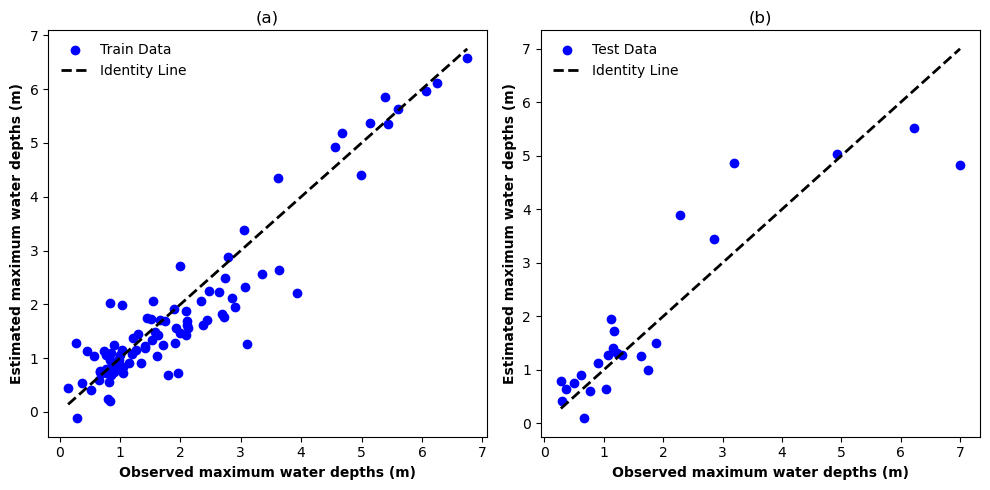

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Scatter plot for simulated vs observed max flood depths (Train Data)
axes[0].scatter(Ytrain, Ytrain_pred, color='blue', label='Train Data')
axes[0].plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=2, label='Identity Line')
axes[0].set_xlabel('Observed maximum water depths (m)', fontweight='bold')
axes[0].set_ylabel('Estimated maximum water depths (m)', fontweight='bold')
axes[0].set_title('(a)')
axes[0].legend(frameon=False)  # No legend box

# Scatter plot for simulated vs observed max flood depths (Test Data)
axes[1].scatter(Ytest, Ytest_pred, color='blue', label='Test Data')
axes[1].plot([Ytest.min(), Ytest.max()], [Ytest.min(), Ytest.max()], 'k--', lw=2, label='Identity Line')
axes[1].set_xlabel('Observed maximum water depths (m)', fontweight='bold')
axes[1].set_ylabel('Estimated maximum water depths (m)', fontweight='bold')
axes[1].set_title('(b)')
axes[1].legend(frameon=False)  # No legend box

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Evaluating stream gauges, HWMs, and stream gagues+HWMs

In [13]:
# Conversion factor from some unit to meters, assuming 'Flood' is initially in some other units
y_stream = df['Flood'] * 0.3048 

# Ensure 'features' contains the correct column names you want to use for the model
x_stream = df[features].copy()

# Scale the data
x_stream_scaled = scaler.fit_transform(x_stream)

In [14]:
#load HWM data
df_HWM = pd.read_csv('HWMs.csv', header=0)


# define necessary columns with the same name
df_HWM['Mean_Gage_height']= 0


# define interaction features
df_HWM["Altittude:Storm surge"] = df_HWM["Altitude"] * df_HWM["Storm surge"]
df_HWM["Storm surge:Flow accumulation"] = df_HWM["Storm surge"] * df_HWM["Flow accumulation"]
df_HWM["Altittude:Soil moisture"] = df_HWM["Altitude"] * df_HWM["Soil moisture"]
df_HWM["Storm surge:Wind speed"] = df_HWM["Storm surge"] * df_HWM["Wind speed"]
df_HWM["Storm surge:Soil moisture"] = df_HWM["Storm surge"] * df_HWM["Soil moisture"]
df_HWM["Storm surge:Mean_Gage_height"] = df_HWM["Mean_Gage_height"] * df_HWM["Storm surge"]
df_HWM["Flow accumulation:Soil moisture"] = df_HWM["Flow accumulation"] * df_HWM["Soil moisture"]


x_HWM = df_HWM[features].copy()

y_HWM = df_HWM['Flood']* 0.3048  #chnage ft to meter


# Scale the data
scaler = StandardScaler()
x_HWM_scaled = scaler.fit_transform(x_HWM)

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error

def evaluate_model(predictions, actuals, model_name):
    # Flatten predictions if necessary
    predictions = predictions.flatten()
    
    # Calculate metrics
    r_squared = np.round(r2_score(actuals, predictions), 2)
    mae = mean_absolute_error(actuals, predictions)
    mdae = median_absolute_error(actuals, predictions)
    nrmse = np.sqrt(mean_squared_error(actuals, predictions)) * 100 / np.mean(actuals)
    bias = np.mean(predictions - actuals)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    # Prepare DataFrame
    errors_df = pd.DataFrame({
        "Metric": ["R-squared", "MAE", "Median Absolute Error", "NRMSE", "BIAS", "RMSE"],
        "Value": [r_squared, mae, mdae, nrmse, bias, rmse]
    })
    
    # Print the DataFrame to check
    print(f"Errors for {model_name}:")
    print(errors_df)

    # Save to CSV
    errors_df.to_csv(f"errors_{model_name}.csv", index=False)

    return errors_df


In [16]:
# Evaluate the model for stream gauges, HWMs, and both streamgauges and HWMs
y_HWM_pred = model.predict(x_HWM_scaled)
errors_df_HWM = evaluate_model(y_HWM_pred, y_HWM, "HWMs_S1")

y_stream_pred = model.predict(x_stream_scaled)
errors_df_stream = evaluate_model(y_stream_pred, y_stream, "Stream_S1")

x_combined = np.concatenate((x_HWM_scaled, x_stream_scaled))
y_combined = np.concatenate((y_HWM, y_stream))
y_combined_pred = model.predict(x_combined)
errors_df_combined = evaluate_model(y_combined_pred, y_combined, "Overall_S1")

8/8 [==============================] - 0s 1ms/step
Errors for HWMs_S1:
                  Metric       Value
0              R-squared   -6.940000
1                    MAE    1.169978
2  Median Absolute Error    1.112819
3                  NRMSE  261.949629
4                   BIAS    1.056673
5                   RMSE    1.348301
4/4 [==============================] - 0s 2ms/step
Errors for Stream_S1:
                  Metric      Value
0              R-squared   0.870000
1                    MAE   0.417516
2  Median Absolute Error   0.319859
3                  NRMSE  28.119713
4                   BIAS  -0.082087
5                   RMSE   0.552054
12/12 [==============================] - 0s 1ms/step
Errors for Overall_S1:
                  Metric       Value
0              R-squared    0.020000
1                    MAE    0.934707
2  Median Absolute Error    0.894810
3                  NRMSE  119.846021
4                   BIAS    0.700619
5                   RMSE    1.159655
